In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import pickle
import time
import random

from core.nuum import NuumActions
from service.gpt import AsyncOpenAIChatAgent

from config import OPENAI, PROXIES, NUUM, POLINA_CLIPS, CLIPS, cookie_path, STICKERS_PACKS, STICKERS

from service.browser import Browser


In [2]:
import random
import time

from selenium.webdriver.common.by import By
import pandas as pd

from service.browser import Browser
from service.gpt import AsyncOpenAIChatAgent
from config import OPENAI, PROXIES, NUUM, POLINA_CLIPS, CLIPS, cookie_path, STICKERS_PACKS, STICKERS



def img_sticker(s):
    s.get_attribute('src')
    # load sticker from url
    # example: 'https://static.nuum.ru/sticker-packs/seal/webp/medium/seal-14.webp'
    import requests
    import io
    from PIL import Image

    url = s.get_attribute('src')
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    return img


def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    # print(sleep)
    time.sleep(max(.5, sleep))


class Elm:
    def __init__(self, el):
        self.class_ = el.get_attribute('class')
        self.text = el.text
        self.tag = el.tag_name
        self.el = el
        self.src = el.get_attribute('src')
        self.location = el.location
        self.link = el.get_attribute('href')

    def click(self):
        self.el.click()

    def get_attribute(self, attr):
        return self.el.get_attribute(attr)


class NuumBaseAction:
    def __init__(self, driver):
        if isinstance(driver, Browser):
            driver = driver.driver
        self.driver = driver
        self.gpt = AsyncOpenAIChatAgent(OPENAI, proxies=PROXIES)
        self.tmp = None

    def find_description(self):
        description_element = self.driver.find_element(By.XPATH, "//app-text-cropper//span[contains(@class, 'text--full')]")
        description_text = self.driver.execute_script("return arguments[0].textContent;", description_element)
        return description_text

    def open(self, url):
        self.driver.get(url)
        self.driver.implicitly_wait(5)

    def like(self, click_liked=False):
        like_button = self.find_like_button()
        if like_button:
            active = 'active' in like_button.class_
            if not active or click_liked:
                like_button.click()
                return True
        return False

    def subscribe(self):
        sbscrs = self.driver.find_elements(By.XPATH, "//span[contains(text(), 'Подписаться')]")
        sbscrs = [Elm(s) for s in sbscrs]
        sbscrs = [s for s in sbscrs if self.in_screen(s)]
        if sbscrs:
            sbscrs[0].click()
            return True
        return False

    def send_sticker(self, only_safe=True):
        # press smile
        element = self.driver.find_elements(By.CLASS_NAME, 'comment-input__smile-button')
        if element:
            element[0].click()
        # select sticker tab
        element = self.driver.find_elements(By.XPATH, "//span[contains(text(), 'Стикеры')]")
        if element:
            element[0].click()
        # select sticker pack
        packs = self.driver.find_elements(By.XPATH, "//img[contains(@class, 'smiles__navigation-sticker')]")
        if packs:
            if only_safe:
                packs = [p for p in packs if p.get_attribute('src').split('/')[-2] in STICKERS_PACKS]
            pack = random.choice(packs)
            pack.click()
            rnd_sleep()
        # select sticker
        stickers = []
        smiles_content = self.driver.find_elements(By.XPATH, "//div[contains(@class, 'smiles__content')]")
        if smiles_content:
            stickers = smiles_content[0].find_elements(By.XPATH, "//img[contains(@class, 'sticker-img-loaded')]")
            # stickers = [Elm(s) for s in stickers]
            # stickers = [s for s in stickers if s.is_displayed()]

            if only_safe:
                stickers = [s for s in stickers if s.get_attribute('src').split('/')[-1] in STICKERS]
        # send sticker
        # tmp.append(stickers)
        if stickers:
            sticker = random.choice(stickers)
            # sticker.click()
            self.driver.execute_script("arguments[0].click();", sticker)
            return True
        return False

    def send_comment(self, text):
        textarea = self.driver.find_elements(By.NAME, 'commentInput')
        if textarea:
            textarea = textarea[0]
            # textarea[0].send_keys(text)
            self.driver.execute_script("""
    var textarea = arguments[0];
    console.log('Тип textarea:', textarea.constructor.name);
    console.log('Имеет dispatchEvent:', typeof textarea.dispatchEvent);

    textarea.value = arguments[1];

    var event = document.createEvent('Event');
    event.initEvent('input', true, true);
    textarea.dispatchEvent(event);
""", textarea, text)
        button = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'input-form__send-button')]")
        if button:
            button[0].click()

    def get_clips_from_page(self):
        elements = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/channel/') and contains(@href, '/clips/')]")
        user_clips = []
        for element in elements:
            link = element.get_attribute('href')
            user_clips.append(link)
        return user_clips

    def generate_comment(self, description):
        prompt = f'Надо написать очень короткий комментарий к тик-ток видео у которого такое описание: !!!" {description}"!!! позитиыный, но не банальный и со смайликами'
        return self.gpt.chat(prompt)

    def find_like_button(self):
        like_buttons = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'reactions__button')]")
        like_buttons = [Elm(b) for b in like_buttons]
        like_buttons = [b for b in like_buttons if self.in_screen(b)]
        if like_buttons:
            return like_buttons[0]
        return None

    def is_liked(self, default=True):
        like_button = self.find_like_button()
        if like_button:
            return 'active' in like_button.class_
        return default

    def next(self):
        next_button = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'large secondary-btn only-icon')]")
        if next_button:
            next_button[-1].click()

    def in_screen(self, el):
        x = el.location['x']
        y = el.location['y']
        return y > 0 and x < 1500

    def find_by_text(self, text, el='span'):
        elements = self.driver.find_elements(By.XPATH, f"//{el}[contains(text(), '{text}')]")
        if elements:
            return elements[0]
        return None

    def user_name(self):
        f = 'shorts-bottom-panel-wrapper'
        user_names = self.driver.find_elements(By.XPATH, f"//div[contains(@class, '{f}')]")
        user_names = [Elm(s) for s in user_names]
        user_names = [s for s in user_names if self.in_screen(s)]
        if user_names:
            return user_names[0].text.split('\n')[0]
        return None


class NuumActions(NuumBaseAction):
    def __init__(self, driver):
        super().__init__(driver)

    def open_rec(self):
        self.open(CLIPS)
        rnd_sleep()
        self.driver.refresh()
        rnd_sleep(1)
        clips = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
        if clips:
            clips[0].click()

    def open_subs(self):
        self.open(CLIPS)
        rnd_sleep()
        self.driver.refresh()
        rnd_sleep(1)
        self.find_by_text('Подписки').click()
        rnd_sleep()
        clips = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
        if clips:
            clips[0].click()

    def like_sticker_subscribe(self, like_ratio=1, sticker_ratio=1, subscribe_ratio=1):
        if not self.is_liked():
            like = sticker = subscribe = False
            if sticker_ratio >= random.random():
                sticker = self.send_sticker()
                rnd_sleep()
            if like_ratio >= random.random():
                like = self.like()
                rnd_sleep()
            if subscribe_ratio >= random.random():
                subscribe = self.subscribe()

            if sticker or like or subscribe:
                name = self.user_name()
                datetime = pd.Timestamp.now()
                return {'name': name, 'sticker': sticker, 'like': like, 'subscribe': subscribe, 'time': datetime}
        return None


Рекоммендации  цикл 4: (2/10)
Всего: 300, лайкнул: 168, стикер: 144, подписался:157
test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2
Подписчики
Всего: 300, лайкнул: 148, стикер: 151, подписался:154
test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2, test2


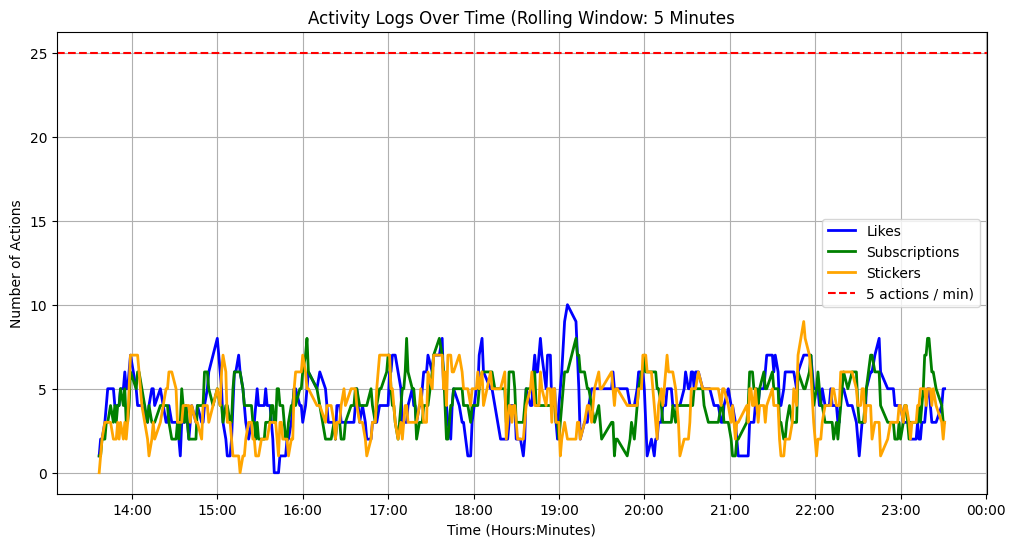

In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output


def generate_test_data():
    """
    Generates test data for the activity log.
    """

    def random_like():
        return random.choice([True, False])

    test_log = [
        [
            {'name': 'test2', 'like': random_like(), 'sticker': random_like(), 'subscribe': random_like(), 'mode': 'rec',
             'time': pd.Timestamp.now() + pd.Timedelta(minutes=random.randint(-300, 300))},
            {'name': 'test2', 'like': random_like(), 'sticker': random_like(), 'subscribe': random_like(), 'mode': 'subs',
             'time': pd.Timestamp.now() + pd.Timedelta(minutes=random.randint(-300, 300))}
        ]
        for _ in range(300)
    ]
    return pd.DataFrame(sum(test_log, []))


def plot_activity_logs(log: pd.DataFrame, window_size: int = 5):
    """
    Plots activity logs for likes, subscriptions, and stickers.

    Parameters:
    log (pd.DataFrame): DataFrame containing the activity log with columns 'time', 'like', 'subscribe', and 'sticker'.
    window_size (int): Size of the rolling window in minutes (default is 5).
    """
    log = log.copy()
    log['minute'] = log['time'].dt.floor('min')  # Round to nearest minute

    def prepare_data(log, activity_column, window_size=window_size):
        actions_per_minute = log.groupby('minute')[activity_column].sum().reset_index(name='actions')
        # Calculate rolling sum
        actions_per_minute['rolling_sum'] = actions_per_minute['actions'].rolling(window=window_size, min_periods=1).sum()

        return actions_per_minute

    # Prepare data for each activity type
    like_data = prepare_data(log, 'like')
    subscribe_data = prepare_data(log, 'subscribe')
    sticker_data = prepare_data(log, 'sticker')

    # Plot each activity type
    plt.figure(figsize=(12, 6))
    for data, label, color in zip([like_data, subscribe_data, sticker_data],
                                  ['Likes', 'Subscriptions', 'Stickers'],
                                  ['blue', 'green', 'orange']):
        if len(data) > 0:
            plt.plot(data['minute'], data['rolling_sum'], label=f'{label}', lw=2, color=color)

    # Add limit line
    plt.axhline(y=5 * window_size, color='r', linestyle='--', label=f'5 actions / min)')

    # Format x-axis as hours and minutes
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.xlabel('Time (Hours:Minutes)')
    plt.ylabel('Number of Actions')
    plt.title(f'Activity Logs Over Time (Rolling Window: {window_size} Minutes')
    plt.legend()
    plt.grid(True)
    plt.show()


def viz_log(log, i, N, c, current_mode='rec'):
    mode = {'rec': 'Рекоммендации', 'subs': 'Подписчики'}
    clear_output()
    for m, name in mode.items():
        df = log[log['mode'] == m]
        all = len(df)
        like = df['like'].astype(int).sum()
        sticker = df['sticker'].astype(int).sum()
        subs = df['subscribe'].astype(int).sum()
        if current_mode == m:
            print(name, f' цикл {c}: ({i}/{N})')
        else:
            print(name)
        print(f'Всего: {all}, лайкнул: {like}, стикер: {sticker}, подписался:{subs}')
        print(', '.join(df.tail(20)['name'].tolist()))
    plot_activity_logs(log, window_size=5)


if __name__ == '__main__':
    test_log = generate_test_data()
    viz_log(test_log, 2, 10, 4)


In [4]:
browser = Browser()
nuum = NuumActions(browser)


In [ ]:
nuum = NuumActions(driver)


In [ ]:
secondary-btn small only-icon
secondary-btn small only-icon
icons-bell-filled
icons-bell

In [25]:
btns = nuum.driver.find_elements(By.XPATH, "//svg[contains(@class, 'ng-star-inserted')]")
#btns = [b.find_elements(By.XPATH, "//svg[contains(@class, 'ng-star-inserted')]") for b in btns]
#btns[5].click()
len(btns)

0

In [71]:
btns = nuum.driver.find_elements(By.XPATH, "//button[contains(@class, 'secondary-btn small only-icon')]")
click = 0
for i,b in enumerate(btns):
    svg = b.find_elements(By.CLASS_NAME, 'ng-star-inserted')
    fill = False
    if svg:
        fill = 'icons-bell-filled' in svg[0].get_attribute('data-inlinesvg')
    if fill:
        b.click()
        #nuum.driver.execute_script("arguments[0].click();", b)
        click += 1
    print(i,'/', len(btns), 'clicked:', click,'                ', end='\r')
    


In [61]:
btns[0].tag_name

'button'

In [55]:
for b in btns:
    b.click()

In [53]:
#btns[0].
#btns[0].find_elements(By.CLASS_NAME, 'ng-star-inserted')[0].get_attribute('class')
btns[10].find_element(By.CLASS_NAME, 'ng-star-inserted').get_attribute('data-inlinesvg') == 'icons-bell-filled'

True

In [22]:
btns

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [21]:
btns[1][0].get_attribute('data-inlinesvg')

IndexError: list index out of range

In [61]:
"""Функция запуска бота в цикле"""

def run_bot(nuum, N, skip_ratio, mode='rec', log=None, c=0, subscribe_ratio=0, pause=1):   
    """ Запуск бота в цикле
    
    Args:
        nuum: NuumActions
        N: int - количество клипов
        skip_ratio: float - вероятность пропуска клипа
        mode: str - 'rec' - рекомендации, 'subs' - подписки
        log: pd.DataFrame - лог
        c: int - номер цикла
        subscribe_ratio: float - вероятность подписки на канал
    """
    if log is None:
        log = pd.DataFrame(columns=['name', 'like', 'sticker', 'subscribe', 'mode', 'time'])
    
    open_page = {'rec': nuum.open_rec, 'subs': nuum.open_subs}
    open_page[mode]()   
    i = 0
    while i < N:        
        if skip_ratio < random.random():
            rnd_sleep()
            result = nuum.like_sticker_subscribe(
                like_ratio = 1, 
                sticker_ratio = 1, 
                subscribe_ratio = subscribe_ratio
            )
            if result:
                result['mode'] = mode
                new_record = pd.DataFrame([result])
                log.loc[len(log)] = new_record.loc[0]
                if log.time.dtype != '<M8[ns]':
                    log.time = pd.to_datetime(log.time)
                viz_log(log, i+1, N, c, mode)
                i += 1
                
            rnd_sleep(pause,3)
        
        if nuum.find_by_text('Комментарии') is None:
            break
                
        rnd_sleep(.5)
        nuum.next()
        

Рекоммендации
Всего: 1, лайкнул: 1, стикер: 0, подписался:0
siuzannakamenskaya
Подписчики  цикл 4: (46/50)
Всего: 2, лайкнул: 2, стикер: 1, подписался:0
Keepkat2907, Wally_nails


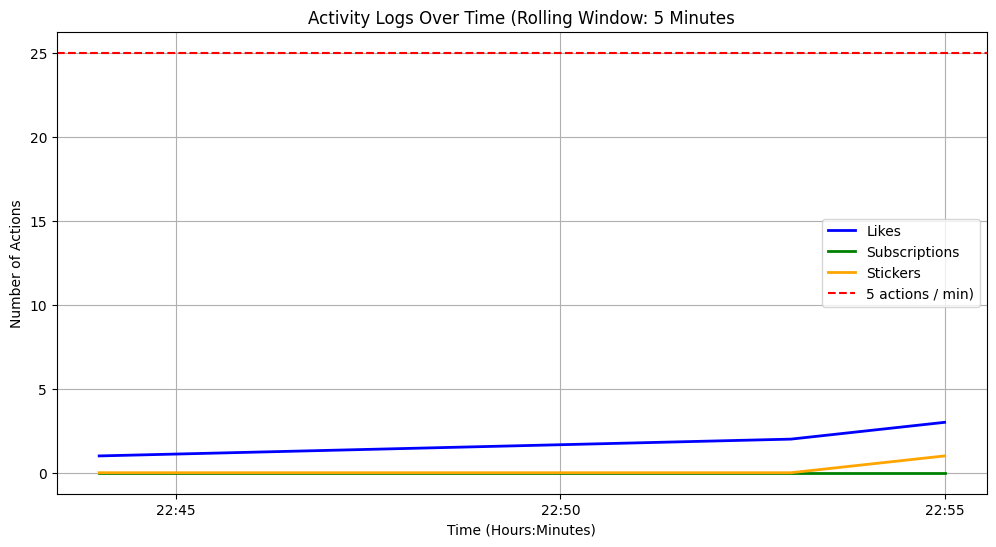


Start rec


KeyboardInterrupt: 

In [59]:
"""
Запуск бота в цикле 
Бот будет просматривать ленту рекомендаций и подписок поочередно
"""

N = 10 # сколько клипов смотрится в каждом цикле
skip_ratio = 0.5 # вероятность пропуска клипа
subscribe_ratio = 0.5 # вероятность подписки на канал
pause = 1 # пауза между клипами

nuum = NuumActions(browser)
nuum.driver.implicitly_wait(2)
c = 0
log = pd.DataFrame(columns=['name', 'like', 'sticker', 'subscribe', 'mode', 'time'])
while True:
    c += 1
    for mode in [ 'rec', 'subs',]:
        try:            
            print(f'Start {mode}')
            rnd_sleep(3)
            run_bot(nuum, N, skip_ratio, mode=mode, log=log, c=c, subscribe_ratio=subscribe_ratio, pause=pause)
            print()
            
        except Exception as e:
            print(e)
            rnd_sleep(5)
    

In [ ]:
N = 10
skip_ratio = 0.5

nuum = NuumActions(driver)
#nuum.open_subs()
nuum.open_rec()

liked = 0
for i in range(N):
    
    if skip_ratio < random.random():
        result = nuum.like_stiker_subscribe(
            like_ratio = 1, 
            stiker_ratio = 1, 
            subscribe_ratio = .5
        )
        if result:
            liked += 1
            print(f'Liked {liked} from {i+1}')
        
        rnd_sleep(3)
    nuum.next()

In [ ]:
nuum.user_name()

In [ ]:
#<div class="info__name-wrapper"><a data-testid="channelInfoChannelName" class="info__link-name" title="Канал PolinaKrusenstern на NUUM" href="/channel/polinakrusenstern"> PolinaKrusenstern </a></div>

f = 'shorts-bottom-panel-wrapper'
user_names = driver.find_elements(By.XPATH, f"//div[contains(@class, '{f}')]")
    #driver.find_elements(By.XPATH, "//div[contains(@href, '/channel/')]")
    
user_names = [Elm(s) for s in user_names]
user_names = [s for s in user_names if nuum.in_screen(s)]
user_names[0].text.split('\n')[0]

In [ ]:
user_names[1].location

In [ ]:
# Открываем Браузер
driver = webdriver.Chrome()
driver.get(NUUM)

# with open(cookie_path, 'rb') as file:
#     cookies = pickle.load(file)
#     for cookie in cookies:
#         driver.add_cookie(cookie)
#         
# driver.get(POLINA_CLIPS)
# driver.implicitly_wait(10)

In [ ]:
with open(cookie_path, 'rb') as file:
    cookies = pickle.load(file)
    for cookie in cookies:
        driver.add_cookie(cookie)

In [ ]:

with open(cookie_path, 'wb') as file:
    pickle.dump(driver.get_cookies(), file)

In [ ]:
nuum = NuumActions(driver)

In [ ]:
nuum.open_subs()

In [ ]:
subs = driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
subs = [Elm(s) for s in subs]
links = [s.link for s in subs]
len(subs), links[0]

In [ ]:
subs[0].click()

In [ ]:
nuum.next()
if not nuum.is_liked():
    time.sleep(2)
    nuum.send_stiker()    
    nuum.like()
    rnd_sleep()
    nuum.subscribe()

In [ ]:
nuum.subscribe()

In [ ]:
nuum.send_stiker()

In [ ]:
nuum.like()

In [ ]:
sbscr = driver.find_elements(By.XPATH, "//span[contains(text(), 'Подписаться')]")
sbscr = [Elm(s) for s in sbscr] 
sbscr = [s for s in sbscr if viewer.in_screen(s)]
sbscr[0].click()

In [ ]:
sbscr = driver.find_elements(By.XPATH, "//span[contains(text(), 'Вы подписаны')]")
sbscr = [Elm(s) for s in sbscr] 
sbscr = [s for s in sbscr if viewer.in_screen(s)]
sbscr[0].click()

In [ ]:
url = random.choice(clips_list)
viewer.open(url)
time.sleep(2)

if not viewer.is_liked():
    descr = viewer.find_description()
    comment = await viewer.generate_comment(descr)
    viewer.send_comment(comment)
    time.sleep(2)
    viewer.send_stiker()
    time.sleep(2)
    viewer.like()
    

In [ ]:
def img_stiker(s):
    s.get_attribute('src')
    # load stiker from url
    # example: 'https://static.nuum.ru/sticker-packs/seal/webp/medium/seal-14.webp'
    import requests
    import io
    from PIL import Image

    url = s.get_attribute('src')
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    return img

def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    #print(sleep)
    time.sleep(max(.5,sleep))


In [ ]:
nuum = NuumViewer(driver)

nuum.open(POLINA_CLIPS)
time.sleep(5)
clips_list = set(nuum.get_clips_from_page())

In [ ]:
clip = random.choice(list(clips_list))
nuum.open(clip)
time.sleep(2)

if not nuum.is_liked():
    descr = nuum.find_description()
    comment = await nuum.generate_comment(descr)
    nuum.send_comment(comment)
    time.sleep(2)
    nuum.send_stiker()
    time.sleep(2)
    nuum.like()

clips_list.remove(clip)
time.sleep(2)

In [ ]:
def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    #print(sleep)
    time.sleep(max(1,sleep))
    
rnd_sleep()

In [ ]:
nuum = NuumViewer(driver)

while clips_list:
    clip = random.choice(list(clips_list))
    nuum.open(clip)
    time.sleep(2)

    if not nuum.is_liked():
        nuum.like()
        descr = nuum.find_description()
        comment = await nuum.generate_comment(descr)
        nuum.send_comment(comment)
        rnd_sleep()
        nuum.send_stiker()
        rnd_sleep()
        

    clips_list.remove(clip)
    rnd_sleep(40, 20)

In [ ]:
nuum = NuumViewer(driver)
nuum.send_stiker()

In [ ]:
element = driver.find_elements(By.XPATH, "//button[contains(@class, 'comment-input__smile-button')]")
if element:
    time.sleep(1)
    element[0].click()

In [ ]:
element = driver.find_elements(By.XPATH, "//span[contains(text(), 'Стикеры')]")

if element:
    time.sleep(1)
    element[0].click()

In [ ]:
time.sleep(2)
#<div _ngcontent-ng-c2079894590="" class="smiles__navigation-sticker-wrapper ng-star-inserted smiles__navigation-sticker-wrapper--active"><img _ngcontent-ng-c2079894590="" class="smiles__navigation-sticker" alt="Енот" src="https://static.nuum.ru/sticker-packs/raccoon/raccoon-icon.webp"></div>
d = driver.find_elements(By.XPATH, "//div[contains(@class, 'smiles__navigation-sticker-wrapper')]")
if d:
    d = random.choice(d)
    d.click()
    time.sleep(1)

In [ ]:
stikers = driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
len(stikers), len(set(stikers))

In [ ]:
stikers = [s.find_elements(By.XPATH, "//img[contains(@class, 'sticker-img-loaded')]") for s in stikers]
len(stikers), len(stikers[0]), len(stikers[1])

In [ ]:
stikers = [s[0] for s in stikers if s]
stikers

In [ ]:
stiker = random.choice(stikers)
img_stiker(stiker)

In [ ]:
len(set(stikers))

In [ ]:
viewer = NuumViewer(driver)
viewer.send_stiker()

In [ ]:
stiker.click()







#<div _ngcontent-ng-c2083850404="" class="sticker ng-star-inserted"><img _ngcontent-ng-c2083850404="" alt="Гном" src="https://static.nuum.ru/sticker-packs/gnom/webp/medium/gnom-12.webp" class="sticker-img-loaded"></div>
stikers = self.driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
stikers = [s.find_elements(By.XPATH, "//img[contains(@class, 'sticker-img-loaded')]") for s in stikers]
stikers = [s[0] for s in stikers if s]

if stikers:
    stiker = random.choice(stikers)
    stiker.click()

In [ ]:
stikers = driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
ss = []
i = 0
for s in stikers:
    stiker = s.find_elements(By.CSS_SELECTOR, '*')
    if stiker:
        if stiker[0].get_attribute('src'):
            ss.append(stiker[0])
    i += 1
    print(i)
    
    
#ss = [s[0] for s in ss if s]
sss = random.choice(list(set(ss)))
#print(len(ss), len(set(ss)))
img_stiker(sss)

In [ ]:
sss = random.choice(list(set(ss)))
sss.get_attribute('src')

In [ ]:
sss.

In [ ]:
print(len(ss), len(set(ss)))